In [4]:
import sys
import numpy as np

from matplotlib import pyplot as plt


import cardio.dataset as ds
from cardio import EcgBatch
index = ds.FilesIndex(path='D:\Projects/cardio/cardio/tests/training2017/A*.hea', no_ext=True, sort=True)

In [32]:
from importlib import reload

In [5]:
from keras.models import Sequential
from keras.layers import Conv1D,  UpSampling1D, Activation, LeakyReLU, Dropout,BatchNormalization
from keras.optimizers import Adam, RMSprop

In [191]:
def generator(batch_size):
    def add_rand_bump(x):
        l=len(x)
        mean = np.random.uniform(0,l-1)
        sig = np.random.uniform(l//1000,l//100)
        bump_width = len(x[int(mean-5*sig):int(mean+5*sig)])
        amp = np.random.uniform(np.max(x),np.max(x)*5)*(np.random.randint(0,2)*2-1)
        x[int(mean-5*sig):int(mean+5*sig)]+=amp*np.exp(-(np.arange(bump_width)-bump_width/2)**2/(2*sig**2))/np.sqrt(2*np.pi*sig**2)
        return x
    def get_batch(batch_size=1):
        eds = ds.Dataset(index, batch_class=EcgBatch)
        batch = eds.next_batch(batch_size=batch_size,shuffle=True, unique_labels=['N'])
        batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])
        return np.array([batch_with_data[i].signal[0][:2000] for i in batch_with_data.indices ])
    while True:
        signal=get_batch(batch_size=batch_size)
        while np.shape(signal)[-1] !=2000: signal=get_batch(batch_size=batch_size)
        noise_sigs = np.zeros_like(signal)
        for i,s in enumerate(signal):
            noise_sigs[i]+=add_rand_bump(np.array(s))
            n_sin = 40
            siglen = len(s)
            t = np.linspace(0, 30, siglen)
            for j in range(n_sin):
                noise_sigs[i]=add_rand_bump(noise_sigs[i])
                #a = np.random.uniform(0, 0.01)
                #omega = np.random.uniform(1, 5)
                #phi = np.random.uniform(0, 2 * np.pi)
                #noise_sigs[i] += a * np.sin(omega * t + phi)
                a = np.random.uniform(0, 0.005)
                #omega = np.random.uniform(15, 30)
                #phi = np.random.uniform(0, 2 * np.pi)
                noise_sigs[i] += a * np.sin(60 * t )
        yield noise_sigs.reshape(-1,2000,1),signal.reshape(-1,2000,1)
    

In [153]:
a=next(generator(1))

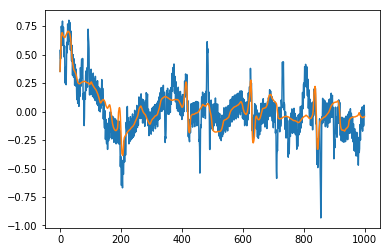

In [154]:
plt.plot(a[0][0])
plt.plot(a[1][0])
plt.show()

In [194]:
import denoiser as d
reload(d)

<module 'denoiser' from 'D:\\Projects\\DeNoiser\\denoiser.py'>

In [195]:
dn = d.DeNoiser([2000],channel=1)

In [196]:
model=dn.denoiser_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
E_con_1 (Conv1D)             (None, 1000, 64)          448       
_________________________________________________________________
leak_1 (LeakyReLU)           (None, 1000, 64)          0         
_________________________________________________________________
drop_1 (Dropout)             (None, 1000, 64)          0         
_________________________________________________________________
con_2 (Conv1D)               (None, 500, 128)          49280     
_________________________________________________________________
leak_2 (LeakyReLU)           (None, 500, 128)          0         
_________________________________________________________________
drop_2 (Dropout)             (None, 500, 128)          0         
_________________________________________________________________
con_3 (Conv1D)               (None, 250, 256)          196864    
__________

In [197]:
model.fit_generator(generator(64), steps_per_epoch=50, epochs=10)

Epoch 1/10
50/50 [==============================] - 17s 343ms/step - loss: 0.1316 - acc: 0.0073
Epoch 2/10
50/50 [==============================] - 9s 190ms/step - loss: 0.0447 - acc: 0.0079
Epoch 3/10
50/50 [==============================] - 10s 193ms/step - loss: 0.0404 - acc: 0.0078
Epoch 4/10
50/50 [==============================] - 10s 190ms/step - loss: 0.0379 - acc: 0.0077
Epoch 5/10
50/50 [==============================] - 9s 190ms/step - loss: 0.0326 - acc: 0.0078
Epoch 6/10
50/50 [==============================] - 9s 189ms/step - loss: 0.0353 - acc: 0.0076
Epoch 7/10
50/50 [==============================] - 9s 190ms/step - loss: 0.0322 - acc: 0.0079
Epoch 8/10
50/50 [==============================] - 10s 192ms/step - loss: 0.0322 - acc: 0.0078
Epoch 9/10
50/50 [==============================] - 9s 189ms/step - loss: 0.0296 - acc: 0.0078
Epoch 10/10
50/50 [==============================] - 9s 189ms/step - loss: 0.0309 - acc: 0.0078


In [232]:
a=next(generator(1))

In [233]:
output=model.predict(a[0])

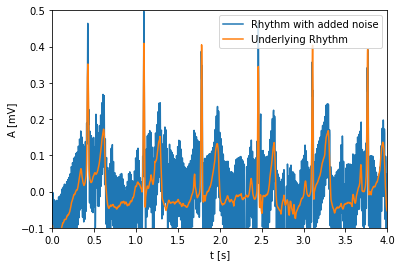

In [257]:
plt.figure(1)
plt.plot(np.arange(2000)/500,a[0][0],label='Rhythm with added noise')
plt.plot(np.arange(2000)/500,a[1][0],label='Underlying Rhythm')
plt.ylabel('A [mV]')
plt.xlabel('t [s]')
plt.legend(loc='upper right')
plt.ylim(-.1,.5)
plt.xlim(0,4)
plt.savefig('noisyecg.png')
plt.show()

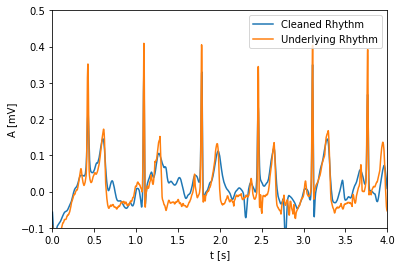

In [258]:
plt.figure(2)

plt.plot(np.arange(2000)/500,output[0], label='Cleaned Rhythm')
plt.plot(np.arange(2000)/500,a[1][0],label='Underlying Rhythm')
plt.ylabel('A [mV]')
plt.xlabel('t [s]')
plt.legend(loc='upper right')
plt.ylim(-.1,.5)
plt.xlim(0,4)

plt.savefig('cleanecg.png')
plt.show()